## **Q1 Element-wise Vector Addition**

In [44]:
%%writefile vector_add.cu
#include<stdio.h>
#include<cuda_runtime.h>

#define N 1024

__global__ void v1(int *a,int *b,int *c){
int i=blockIdx.x*blockDim.x+threadIdx.x;
if(i<N)
c[i]=a[i]+b[i];
}

int main(){
int *h1,*h2,*h3;
int *d1,*d2,*d3;
int s=N*sizeof(int);

h1=(int*)malloc(s);
h2=(int*)malloc(s);
h3=(int*)malloc(s);

for(int i=0;i<N;i++){
h1[i]=i;
h2[i]=i;
}

cudaMalloc((void**)&d1,s);
cudaMalloc((void**)&d2,s);
cudaMalloc((void**)&d3,s);

cudaMemcpy(d1,h1,s,cudaMemcpyHostToDevice);
cudaMemcpy(d2,h2,s,cudaMemcpyHostToDevice);

v1<<<(N+255)/256,256>>>(d1,d2,d3);

cudaMemcpy(h3,d3,s,cudaMemcpyDeviceToHost);

printf("First 10 results:\n");
for(int i=0;i<10;i++)
printf("%d ",h3[i]);

printf("\n");

cudaFree(d1);cudaFree(d2);cudaFree(d3);
free(h1);free(h2);free(h3);
return 0;
}

Overwriting vector_add.cu


In [45]:
!nvcc -arch=sm_75 vector_add.cu -o vector_add

In [46]:
!./vector_add

First 10 results:
0 2 4 6 8 10 12 14 16 18 


## **Q2 Vector Addition using Thrust Library**

In [47]:
%%writefile vector_thrust.cu
#include<thrust/device_vector.h>
#include<thrust/host_vector.h>
#include<iostream>

#define N 1024

int main(){
thrust::host_vector<int> h1(N),h2(N);

for(int i=0;i<N;i++){
h1[i]=i;
h2[i]=i;
}

thrust::device_vector<int> d1=h1;
thrust::device_vector<int> d2=h2;
thrust::device_vector<int> d3(N);

thrust::transform(d1.begin(),d1.end(),d2.begin(),d3.begin(),thrust::plus<int>());

thrust::host_vector<int> h3=d3;

std::cout<<"First 10 results:\n";
for(int i=0;i<10;i++)
std::cout<<h3[i]<<" ";

std::cout<<std::endl;
return 0;
}

Overwriting vector_thrust.cu


In [48]:
!nvcc -arch=sm_75 vector_thrust.cu -o vector_thrust

In [49]:
!./vector_thrust

First 10 results:
0 2 4 6 8 10 12 14 16 18 


## **Q3 Dot Product using Thrust**

In [50]:
%%writefile dot_product.cu
#include<thrust/device_vector.h>
#include<thrust/host_vector.h>
#include<thrust/inner_product.h>
#include<iostream>
#include<chrono>

#define N 1024

int main(){
thrust::host_vector<int> h1(N),h2(N);

for(int i=0;i<N;i++){
h1[i]=i;
h2[i]=i;
}

auto c1=std::chrono::high_resolution_clock::now();
long long r1=0;
for(int i=0;i<N;i++)
r1+=h1[i]*h2[i];
auto c2=std::chrono::high_resolution_clock::now();

thrust::device_vector<int> d1=h1;
thrust::device_vector<int> d2=h2;

auto g1=std::chrono::high_resolution_clock::now();
int r2=thrust::inner_product(d1.begin(),d1.end(),d2.begin(),0);
auto g2=std::chrono::high_resolution_clock::now();

std::cout<<"CPU Result: "<<r1<<std::endl;
std::cout<<"GPU Result: "<<r2<<std::endl;

return 0;
}

Overwriting dot_product.cu


In [51]:
!nvcc -arch=sm_75 dot_product.cu -o dot_product

In [52]:
!./dot_product

CPU Result: 357389824
GPU Result: 357389824


## **Q4 Matrix Multiplication**

In [53]:
%%writefile matrix_mul.cu
#include<stdio.h>
#define N 16

__global__ void m1(int *a,int *b,int *c){
int r=threadIdx.y;
int cl=threadIdx.x;
int s=0;
for(int k=0;k<N;k++)
s+=a[r*N+k]*b[k*N+cl];
c[r*N+cl]=s;
}

int main(){
int A[N*N],B[N*N],C[N*N];

for(int i=0;i<N*N;i++){
A[i]=1;
B[i]=1;
}

int *d1,*d2,*d3;
int sz=N*N*sizeof(int);

cudaMalloc(&d1,sz);
cudaMalloc(&d2,sz);
cudaMalloc(&d3,sz);

cudaMemcpy(d1,A,sz,cudaMemcpyHostToDevice);
cudaMemcpy(d2,B,sz,cudaMemcpyHostToDevice);

dim3 t(N,N);
m1<<<1,t>>>(d1,d2,d3);

cudaMemcpy(C,d3,sz,cudaMemcpyDeviceToHost);

printf("C[0]=%d\n",C[0]);
return 0;
}

Overwriting matrix_mul.cu


In [54]:
!nvcc -arch=sm_75 matrix_mul.cu -o matrix_mul


In [55]:
!./matrix_mul

C[0]=16


Why matrix multiplication needs more computation than vector addition

Each element requires only one operation:

C[i]=A[i]+B[i]

For size N, total operations = N
Time Complexity: O(N)

Each element of result matrix requires a full dot product:
C[i][j]=A[i][0]×B[0][j] + A[i][1]×B[1][j] + ... + A[i][N−1]×B[N−1][j]

So for each element:
N multiplications
N−1 additions
Total operations per element ≈ 2N
Since matrix has N×N elements:
Total operations≈N×N×N=N³
Time Complexity: O(N³)
For 16×16 case
Vector addition(size 16)=16 operations
Matrix multiplication=16×16×16=4096 multiplications

Hence, Matrix multiplication requires far more computation because each output element depends on an entire row and column, not just one pair of elements.

## **Q5 Vector Addition Comparison**

CPU Sequential (C/C++)

In [56]:
%%writefile vector_add_cpu.cu
#include<iostream>
#include<chrono>

#define N 5000000

int main(){
int *a=new int[N];
int *b=new int[N];
int *c=new int[N];

for(int i=0;i<N;i++){
a[i]=i;
b[i]=i;
}

auto s=std::chrono::high_resolution_clock::now();

for(int i=0;i<N;i++)
c[i]=a[i]+b[i];

auto e=std::chrono::high_resolution_clock::now();

double t=std::chrono::duration<double>(e-s).count();

std::cout<<"CPU Time: "<<t<<" seconds"<<std::endl;

delete[] a;delete[] b;delete[] c;
return 0;
}

Overwriting vector_add_cpu.cu


In [57]:
!nvcc -arch=sm_75 vector_add_cpu.cu -o vector_add_cpu

In [58]:
!./vector_add_cpu

CPU Time: 0.0228569 seconds


CUDA Kernel Implementation

In [59]:
%%writefile vector_add_cuda.cu
#include<iostream>
#include<cuda_runtime.h>

#define N 5000000

__global__ void k1(int *a,int *b,int *c){
int i=blockIdx.x*blockDim.x+threadIdx.x;
if(i<N)
c[i]=a[i]+b[i];
}

int main(){
int *h1=new int[N];
int *h2=new int[N];
int *h3=new int[N];

for(int i=0;i<N;i++){
h1[i]=i;
h2[i]=i;
}

int *d1,*d2,*d3;
int s=N*sizeof(int);

cudaMalloc(&d1,s);
cudaMalloc(&d2,s);
cudaMalloc(&d3,s);

cudaMemcpy(d1,h1,s,cudaMemcpyHostToDevice);
cudaMemcpy(d2,h2,s,cudaMemcpyHostToDevice);

cudaEvent_t st,sp;
cudaEventCreate(&st);
cudaEventCreate(&sp);

cudaEventRecord(st);

k1<<<(N+255)/256,256>>>(d1,d2,d3);

cudaEventRecord(sp);
cudaEventSynchronize(sp);

float ms=0;
cudaEventElapsedTime(&ms,st,sp);

std::cout<<"CUDA Kernel Time: "<<ms/1000<<" seconds"<<std::endl;

cudaFree(d1);cudaFree(d2);cudaFree(d3);
delete[] h1;delete[] h2;delete[] h3;
return 0;
}

Overwriting vector_add_cuda.cu


In [60]:
!nvcc -arch=sm_75 vector_add_cuda.cu -o vector_add_cuda

In [61]:
!./vector_add_cuda

CUDA Kernel Time: 0.000277856 seconds


Thrust Implementation

In [62]:
%%writefile vector_add_thrust.cu
#include<thrust/device_vector.h>
#include<thrust/transform.h>
#include<iostream>
#include<cuda_runtime.h>

#define N 5000000

int main(){
thrust::device_vector<int> d1(N);
thrust::device_vector<int> d2(N);
thrust::device_vector<int> d3(N);

for(int i=0;i<N;i++){
d1[i]=i;
d2[i]=i;
}

cudaEvent_t st,sp;
cudaEventCreate(&st);
cudaEventCreate(&sp);

cudaEventRecord(st);

thrust::transform(d1.begin(),d1.end(),d2.begin(),d3.begin(),thrust::plus<int>());

cudaEventRecord(sp);
cudaEventSynchronize(sp);

float ms=0;
cudaEventElapsedTime(&ms,st,sp);

std::cout<<"Thrust Time: "<<ms/1000<<" seconds"<<std::endl;

return 0;
}

Overwriting vector_add_thrust.cu


In [63]:
!nvcc -arch=sm_75 vector_add_thrust.cu -o vector_add_thrust

In [64]:
!./vector_add_thrust

Thrust Time: 0.000331072 seconds


RAPIDS (CuPy) Implementation

In [72]:
import cupy as cp
import time

n=5_000_000

a=cp.arange(n)
b=cp.arange(n)

_=a+b
cp.cuda.Stream.null.synchronize()

s=time.time()
c=a+b
cp.cuda.Stream.null.synchronize()
e=time.time()

print("RAPIDS (CuPy) Time:",e-s,"seconds")

RAPIDS (CuPy) Time: 0.0009551048278808594 seconds


In [74]:
import pandas as pd

d={
"Method":["CPU","CUDA Kernel","Thrust","RAPIDS"],
"Time (seconds)":[0.0228569,0.000277856,0.000331072,0.0009551048278808594]
}

df=pd.DataFrame(d)
df

,Method,Time (seconds)
0,CPU,0.022857
1,CUDA Kernel,0.000278
2,Thrust,0.000331
3,RAPIDS,0.000955


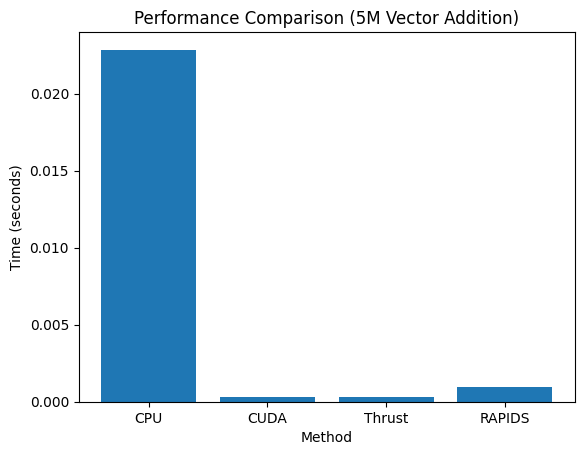

In [73]:
import matplotlib.pyplot as plt

m=["CPU","CUDA","Thrust","RAPIDS"]
t=[0.0228569,0.000277856,0.000331072,0.0009551048278808594]

plt.bar(m,t)
plt.xlabel("Method")
plt.ylabel("Time (seconds)")
plt.title("Performance Comparison (5M Vector Addition)")
plt.show()

## **Q6 Sum of all elements using Thrust**

In [75]:
%%writefile thrust_sum.cu
#include<thrust/device_vector.h>
#include<thrust/reduce.h>
#include<iostream>

int main(){
thrust::device_vector<int> d(10);

for(int i=0;i<10;i++)
d[i]=i+1;

int s=thrust::reduce(d.begin(),d.end());

std::cout<<"Sum = "<<s<<std::endl;
return 0;
}

Writing thrust_sum.cu


In [76]:
!nvcc -arch=sm_75 thrust_sum.cu -o thrust_sum

In [77]:
!./thrust_sum

Sum = 55


## **Q7 Sort a vector on GPU using Thrust**

In [78]:
%%writefile sort_vector.cu
#include<thrust/device_vector.h>
#include<thrust/sort.h>
#include<iostream>

int main(){
int a[8]={7,2,9,1,5,3,8,4};

thrust::device_vector<int> d(a,a+8);

std::cout<<"Before Sorting:\n";
for(int i=0;i<8;i++)
std::cout<<d[i]<<" ";

std::cout<<std::endl;

thrust::sort(d.begin(),d.end());

std::cout<<"After Sorting:\n";
for(int i=0;i<8;i++)
std::cout<<d[i]<<" ";

std::cout<<std::endl;
return 0;
}

Writing sort_vector.cu


In [79]:
!nvcc -arch=sm_75 sort_vector.cu -o sort_vector

In [80]:
!./sort_vector

Before Sorting:
7 2 9 1 5 3 8 4 
After Sorting:
1 2 3 4 5 7 8 9 
